### Imports

In [1]:
%matplotlib inline

In [2]:
from fastai.imports import *
from fastai.structured import *

from pandas_summary import DataFrameSummary
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from IPython.display import display

from sklearn import metrics
np.random.seed(1)


In [3]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

### Fresh data loading

In [4]:
PATH = './data/'

In [5]:
!ls {PATH}

all.zip		      sample_submission.csv	test.csv     train.csv
data_description.txt  sample_submission.csv.gz	test.csv.gz  train.csv.gz


In [7]:
df_raw = pd.read_csv(f'{PATH}train.csv', low_memory=False, 
                     parse_dates=['MoSold','YrSold','YearBuilt','YearRemodAdd','GarageYrBlt'])

### Exploration

In [8]:
def display_all(df):
    with pd.option_context("display.max_rows", 1000): 
        with pd.option_context("display.max_columns", 1000): 
            display(df)

In [ ]:
display_all(df_raw.head().T)

In [ ]:
display_all(df_raw.describe(include='all').T)

#### Transforming data

In [9]:
df_raw.SalePrice = np.log(df_raw.SalePrice)

In [10]:
train_cats(df_raw)

In [11]:
add_datepart(df_raw, 'YrSold')
add_datepart(df_raw, 'YearBuilt')
add_datepart(df_raw, 'YearRemodAdd')
add_datepart(df_raw, 'GarageYrBlt')

In [12]:
os.makedirs('tmp', exist_ok=True)
df_raw.to_feather('tmp/houseprices-raw')

Storing data in feather format, then reloading and processing by spliting training data and response variable, then converting everything into numbers.

In [13]:
import feather
df_raw = feather.read_dataframe('tmp/houseprices-raw')

In [14]:
df, y, nas = proc_df(df_raw, 'SalePrice')

In [15]:
m = RandomForestRegressor(n_jobs=-1)
m.fit(df, y)
m.score(df,y)

0.9759922768446568

#### Spliting data, and defining some functions

In [16]:
def split_vals(a,n): return a[:n].copy(), a[n:].copy()

# Test set size
n_valid = 400
# Train set size
n_trn = len(df)-n_valid

raw_train, raw_valid = split_vals(df_raw, n_trn)
X_train, X_valid = split_vals(df, n_trn)
y_train, y_valid = split_vals(y, n_trn)


In [17]:
def rmse(x,y): return math.sqrt(((x-y)**2).mean())

def print_score(m):
    """
    Printing order:
    Training Loss, Validation Loss, training R2, Validation R2.
    """
    res = [rmse(m.predict(X_train), y_train), rmse(m.predict(X_valid), y_valid),
                m.score(X_train, y_train), m.score(X_valid, y_valid)]
    if hasattr(m, 'oob_score_'): res.append(m.oob_score_)
    print(res)

### Default RF trail

In [18]:
# Default
m = RandomForestRegressor(n_jobs=-1, random_state=1)
%time m.fit(X_train, y_train)
print_score(m)

CPU times: user 247 ms, sys: 3.61 ms, total: 251 ms
Wall time: 118 ms
[0.06574898621967994, 0.1512915593139064, 0.9738730089686771, 0.8402830709417434]


#### Single tree trail and plotting to understand

In [19]:
# Single tree
m = RandomForestRegressor(n_estimators=1, max_depth=3, bootstrap=False, n_jobs=-1, random_state=1)
%time m.fit(X_train, y_train)
print_score(m)

CPU times: user 20.5 ms, sys: 2 ms, total: 22.5 ms
Wall time: 117 ms
[0.21168554305506201, 0.23122825859747456, 0.7291719312935655, 0.6269187955728914]


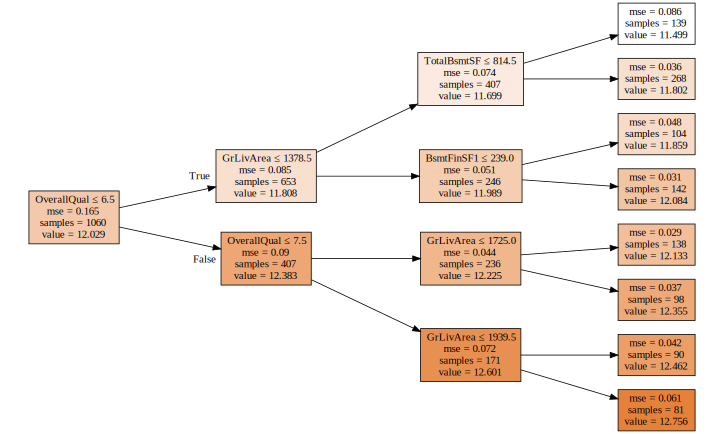

In [20]:
draw_tree(m.estimators_[0], X_train, precision=3)

### Bagging experiments

In [21]:
m = RandomForestRegressor(n_jobs=-1, random_state=1)
m.fit(X_train, y_train)
print_score(m)

[0.06574898621967998, 0.1512915593139064, 0.9738730089686771, 0.8402830709417436]


#### Predicting with each tree, on single example

In [22]:
preds = np.stack([t.predict(X_valid) for t in m.estimators_])
preds[:,0], np.mean(preds[:,0]), y_valid[0]

(array([12.17819, 12.23563, 12.3737 , 12.87902, 12.41105, 12.87902, 12.32386, 12.3737 , 12.1495 , 12.10016]),
 12.390382672256948,
 12.271392111650817)

In [23]:
preds.shape

(10, 400)

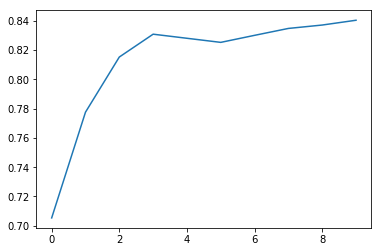

In [24]:
plt.plot([metrics.r2_score(y_valid, np.mean(preds[:i+1], axis=0)) for i in range(10)]);

#### Trying more estimators

In [25]:
m = RandomForestRegressor(n_estimators=20, n_jobs=-1, random_state=1)
m.fit(X_train, y_train)
print_score(m)

[0.06137932312129362, 0.14609996098283015, 0.9772303967071445, 0.8510564320833057]


In [26]:
m = RandomForestRegressor(n_estimators=40, n_jobs=-1, random_state=1)
m.fit(X_train, y_train)
print_score(m)

[0.0576417616993992, 0.1434183695709812, 0.9799189801344811, 0.8564738236218608]


In [27]:
m = RandomForestRegressor(n_estimators=80, n_jobs=-1, random_state=1)
m.fit(X_train, y_train)
print_score(m)

[0.05584811570577004, 0.1403242158054702, 0.9811492634466256, 0.862599978428384]


In [28]:
m = RandomForestRegressor(n_estimators=160, n_jobs=-1, random_state=1)
m.fit(X_train, y_train)
print_score(m)

[0.05515916086264726, 0.14200253697431942, 0.9816114884984417, 0.8592936296928363]


In [29]:
preds = np.stack([t.predict(X_valid) for t in m.estimators_])
# preds[:,0], np.mean(preds[:,0]), y_valid[0]

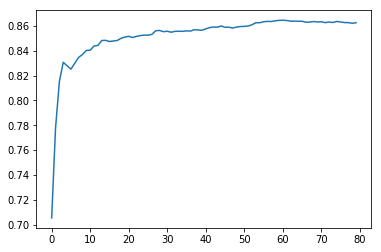

In [30]:
plt.plot([metrics.r2_score(y_valid, np.mean(preds[:i+1], axis=0)) for i in range(80)]);

In [31]:
m = RandomForestRegressor(n_estimators=60, n_jobs=-1, random_state=1)
m.fit(X_train, y_train)
print_score(m)

[0.056459048981764896, 0.1393600988387213, 0.9807345839923204, 0.8644815441379754]


#### Trying out of bag parametr

In [32]:
m = RandomForestRegressor(n_estimators=40, oob_score=True, n_jobs=-1)
m.fit(X_train, y_train)
print_score(m)
m = RandomForestRegressor(n_estimators=40, oob_score=True, n_jobs=-1)
m.fit(X_train, y_train)
print_score(m)
m = RandomForestRegressor(n_estimators=40, oob_score=True, n_jobs=-1)
m.fit(X_train, y_train)
print_score(m)

[0.05825314495998931, 0.14223338796677545, 0.979490738223577, 0.8588357701532265, 0.8539414216556724]
[0.05794352783787125, 0.1411207137563594, 0.9797081734658317, 0.8610357519073614, 0.854041526198531]
[0.05902157256881147, 0.14789751427318576, 0.9789460868160711, 0.8473688055734511, 0.8560338700655437]


Hard to what is happing as out of bag score is sometimes more than validation score and sometimes not.
But the difference doesn't seem to be very high.
Need to fix the seed here.

### Subsampling for out of bag approach

In [33]:
df_trn, y_trn, nas = proc_df(df_raw, 'SalePrice')
X_train, X_valid = split_vals(df_trn, n_trn)
y_train, y_valid = split_vals(y_trn, n_trn)

In [34]:
set_rf_samples(1000)

In [35]:
m = RandomForestRegressor(n_jobs=-1, oob_score=True, random_state=1)
%time m.fit(X_train, y_train)
print_score(m)

/home/shubham/Downloads/exit/lib/python3.6/site-packages/sklearn/ensemble/forest.py:732: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "


CPU times: user 247 ms, sys: 3.88 ms, total: 251 ms
Wall time: 130 ms
[0.07104898919815886, 0.1547458775220996, 0.9694910625973859, 0.8329064332904339, -5.70015203095804]


In [36]:
m = RandomForestRegressor(n_estimators=500, n_jobs=-1, oob_score=True, random_state=1)
%time m.fit(X_train, y_train)
print_score(m)

CPU times: user 11.5 s, sys: 56.2 ms, total: 11.5 s
Wall time: 3.42 s
[0.05736199003516815, 0.1406586672442693, 0.9801134386693224, 0.8619442341859406, 0.8690681508297415]


#### Trying min samples leaf

In [37]:
m = RandomForestRegressor(n_estimators=60, n_jobs=-1, min_samples_leaf=3, oob_score=True, random_state=1)
%time m.fit(X_train, y_train)
print_score(m)

CPU times: user 963 ms, sys: 10.7 ms, total: 974 ms
Wall time: 368 ms
[0.08022110231987165, 0.1437454538822458, 0.9611054702412524, 0.8558184167451447, 0.8564595906716586]


In [38]:
m = RandomForestRegressor(n_estimators=60, n_jobs=-1, min_samples_leaf=5, oob_score=True, random_state=1)
%time m.fit(X_train, y_train)
print_score(m)

CPU times: user 810 ms, sys: 7.32 ms, total: 818 ms
Wall time: 366 ms
[0.09777982340692314, 0.14696275046527102, 0.9422157113015952, 0.8492920730759559, 0.8528524507343405]


In [39]:
m = RandomForestRegressor(n_estimators=60, n_jobs=-1, min_samples_leaf=10, oob_score=True, random_state=1)
%time m.fit(X_train, y_train)
print_score(m)

CPU times: user 656 ms, sys: 3.96 ms, total: 660 ms
Wall time: 268 ms
[0.12240753053796687, 0.1533211526715657, 0.9094418488020171, 0.8359690861548025, 0.845405762429244]


In [40]:
m = RandomForestRegressor(n_estimators=60, n_jobs=-1, min_samples_leaf=15, oob_score=True, random_state=1)
%time m.fit(X_train, y_train)
print_score(m)

CPU times: user 570 ms, sys: 7.43 ms, total: 578 ms
Wall time: 267 ms
[0.13546196929051427, 0.16008570813989242, 0.8890962977346502, 0.8211756413779543, 0.836611547452913]


#### Trying max features

In [41]:
reset_rf_samples()

In [42]:
m = RandomForestRegressor(n_estimators=40, n_jobs=-1, max_features=0.5, oob_score=True, random_state=1)
%time m.fit(X_train, y_train)
print_score(m)

CPU times: user 542 ms, sys: 4.49 ms, total: 547 ms
Wall time: 252 ms
[0.055418970894466985, 0.1384750963532731, 0.9814378538313372, 0.8661972913558492, 0.8641336519070981]


In [43]:
m = RandomForestRegressor(n_estimators=1000, n_jobs=-1, max_features=0.5, oob_score=True, random_state=1)
%time m.fit(X_train, y_train)
print_score(m)

CPU times: user 13.2 s, sys: 80.7 ms, total: 13.2 s
Wall time: 4.07 s
[0.05291206728169283, 0.13621963120016292, 0.9830792061608639, 0.8705205179464763, 0.8759796581944645]


In [ ]:
??set_rf_samples